In [5]:
import sys

sys.path.insert(0, '/apps/pytorch/2.1.1-py312-cu122-mpi/lib/python3.12/site-packages')

In [6]:
import torch
from torchvision.io import decode_image
import transformers
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [7]:
# Device:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
# Load model:
ckpt_name = 'aehrc/cxrmate-rrg24'
tokenizer = transformers.AutoTokenizer.from_pretrained(ckpt_name)
model = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device=device)
model.eval()

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Resize(size=model.config.encoder.image_size, antialias=True),
        v2.CenterCrop(size=[model.config.encoder.image_size]*2),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=model.config.encoder.image_mean, std=model.config.encoder.image_std),
    ]
)
        

/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


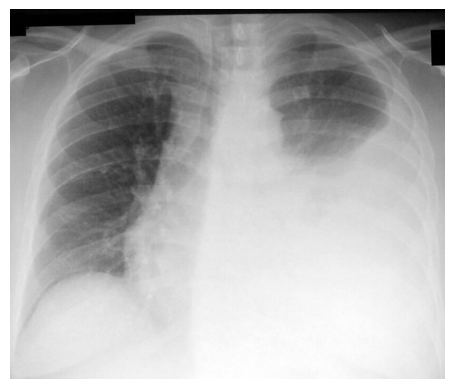

In [9]:
# Get example CXR:
url = 'https://upload.wikimedia.org/wikipedia/commons/5/57/Left-sided_Pleural_Effusion.jpg'
with urllib.request.urlopen(url) as url:
    image = url.read()
image = bytearray(image)
image = torch.frombuffer(image, dtype=torch.uint8)
image = decode_image(image)
image_np = image.numpy()
image_np = (image_np / np.max(image_np) * 255).astype(np.uint8)
plt.imshow(image_np.transpose(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# Beam search:
image = transforms(image).to(device=device)
output_ids = model.generate(
    pixel_values=image.unsqueeze(0).unsqueeze(0),
    max_length=512,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')], [tokenizer.convert_tokens_to_ids('[NI]')]],
    num_beams=4,
    use_cache=True,
)

# Findings and impression sections:
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)

In [11]:
findings[0]

'The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is a large left pleural effusion. Underlying consolidation cannot be excluded. No pneumothorax is identified.'

In [12]:
impression[0]

'1. Large left pleural effusion. Underlying pneumonia cannot be excluded. 2. Underlying pulmonary vascularity.'